In [222]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.manifold import TSNE
import umap

%matplotlib notebook

In [223]:
url_confirmed_us = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
url_deaths_us = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'
url_confirmed_global = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url_deaths_global = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
url_recovered_global = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'


# Import urls as dataframes

confirmed_dat = pd.read_csv(url_confirmed_global)
deaths_dat = pd.read_csv(url_deaths_global)

In [224]:
# Have data as countries and dates only
cdat = np.asarray(confirmed_dat[['Country/Region'] + list(confirmed_dat.columns[4:])])
ddat = np.asarray(deaths_dat[['Country/Region'] + list(deaths_dat.columns[4:])])

In [225]:
# Find nonzero dates
starts = []
for country in cdat:
    try:
        nonzero = np.nonzero(country[1:])[0][0] + 1
        starts.append(nonzero)
    except:
        starts.append(len(country))
starts = np.asarray(starts)

In [241]:
# Time-frame the data, ie. align in time from the first case
days_from_start = 50
days_total = cdat.shape[1]
mask = days_total - starts >= days_from_start

timeframed_cdat = []
for i in range(len(cdat[mask])):
    timeframed_cdat.append(cdat[mask][i,starts[mask][i]:starts[mask][i] + days_from_start])
tf_cdat = np.asarray(timeframed_cdat)

In [242]:
# Normalize
normalized = tf_cdat /np.max(tf_cdat,axis=1)[:,None]

In [243]:
emb_umap = umap.UMAP(verbose=2,n_neighbors=5,n_epochs = 2500).fit_transform(normalized)
# pd.DataFrame(emb_umap).to_pickle("embedded.dat")

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=2500,
     n_neighbors=5, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=None, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=2)
Construct fuzzy simplicial set
Mon Apr 13 13:33:33 2020 Finding Nearest Neighbors
Mon Apr 13 13:33:33 2020 Finished Nearest Neighbor Search
Mon Apr 13 13:33:33 2020 Construct embedding
	completed  0  /  2500 epochs
	completed  250  /  2500 epochs
	completed  500  /  2500 epochs
	completed  750  /  2500 epochs
	completed  1000  /  2500 epochs
	completed  1250  /  2500 epochs
	comp

In [244]:
def interactive_plot(embedding,data):

    # Setup axes
    fig, ax = plt.subplots(figsize = (9, 6), ncols = 2)
    ax_emb = ax[0]
    ax_show = ax[1]

    # Plot embedding
    emb_plot = ax_emb.scatter(embedding[:, 0], embedding[:, 1],cmap='plasma',c = np.log((np.max(data,axis=1)).astype(float)))
    
    # Marker plot
    colors = ['r', 'g', 'k', 'orange', 'purple']
    marked_scat = ax_emb.scatter([], [], marker = 'x', s = 60)

    def clicker(event):
        dist_x = embedding[:, 0] - event.xdata
        dist_y = embedding[:, 1] - event.ydata
        dist_sq = pd.Series(dist_x ** 2 + dist_y ** 2)
        dist_sq.sort_values(inplace = True)

        marked_scat.set_offsets(embedding[dist_sq.index[:5], :])
        marked_scat.set_color(colors)

        ax_show.cla()
        for i in range(5):
            ax_show.plot(range(len(data[dist_sq.index[i], :])), data[dist_sq.index[i], :], ls = '--', label = cdat[mask][dist_sq.index[i],0], color = colors[i])
    
        ax_show.legend()
    plt.draw()
    
    cid = fig.canvas.mpl_connect('button_press_event', clicker)

<IPython.core.display.Javascript object>


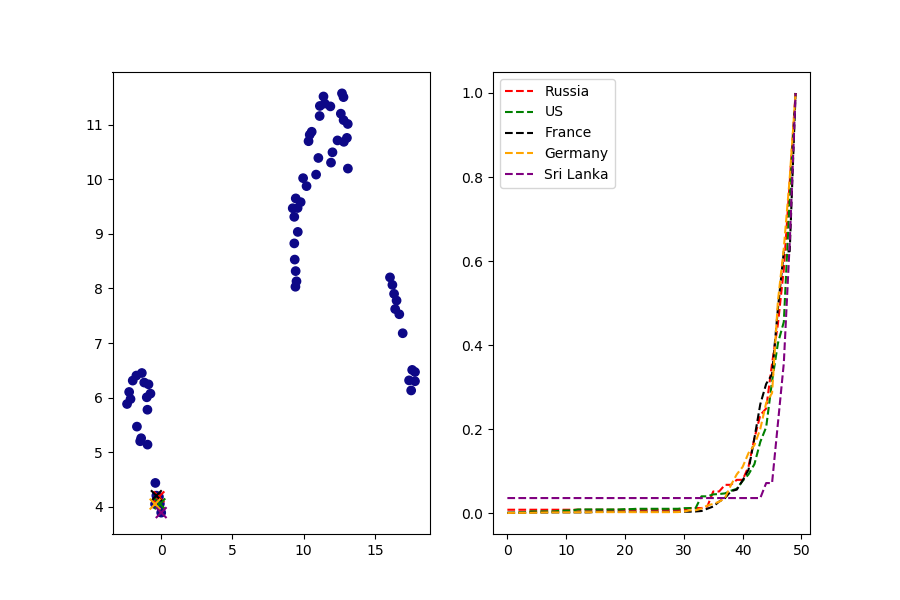

In [246]:
# interactive_plot(emb_umap,cdat[mask][:,1:])
interactive_plot(emb_umap,normalized)